In [ ]:
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# NOTE
#### Make sure that this notebook is using `smug` kernel

In [ ]:
import os
if not os.path.exists('data'):
  ! mkdir data
  ! wget wget -q -P data/ --show-progress http://people.csail.mit.edu/taolei/beer/annotations.json
  ! wget wget -q -P data/ --show-progress http://people.csail.mit.edu/taolei/beer/review+wiki.filtered.200.txt.gz
  ! wget wget -q -P data/ --show-progress http://people.csail.mit.edu/taolei/beer/reviews.260k.heldout.txt.gz
  ! wget wget -q -P data/ --show-progress http://people.csail.mit.edu/taolei/beer/reviews.260k.train.txt.gz
  ! wget wget -q -P data/ --show-progress http://people.csail.mit.edu/taolei/beer/reviews.aspect0.heldout.txt.gz
  ! wget wget -q -P data/ --show-progress http://people.csail.mit.edu/taolei/beer/reviews.aspect0.train.txt.gz
  ! wget wget -q -P data/ --show-progress http://people.csail.mit.edu/taolei/beer/reviews.aspect1.heldout.txt.gz
  ! wget wget -q -P data/ --show-progress http://people.csail.mit.edu/taolei/beer/reviews.aspect1.train.txt.gz
  ! wget wget -q -P data/ --show-progress http://people.csail.mit.edu/taolei/beer/reviews.aspect2.heldout.txt.gz
  ! wget wget -q -P data/ --show-progress http://people.csail.mit.edu/taolei/beer/reviews.aspect2.train.txt.gz

annotations.json    100%[===================>]   2.21M   798KB/s    in 2.8s    
review+wiki.filtere 100%[===================>]  95.50M   435KB/s    in 2m 51s  
reviews.260k.heldou 100%[===================>]   7.70M   457KB/s    in 25s     
reviews.260k.train. 100%[===================>]  56.66M  1.12MB/s    in 89s     
reviews.aspect0.hel 100%[===================>]   2.56M   617KB/s    in 4.2s    
reviews.aspect0.tra 100%[===================>]  20.20M   451KB/s    in 52s     
reviews.aspect1.hel 100%[===================>]   2.54M   436KB/s    in 6.9s    
reviews.aspect1.tra 100%[===================>]  17.87M   404KB/s    in 52s     
reviews.aspect2.hel 100%[===================>]   2.59M   530KB/s    in 6.4s    
reviews.aspect2.tra 100%[===================>]  18.19M   738KB/s    in 20s     


In [ ]:
import gzip
import json

from IPython.display import clear_output, display, Image, HTML
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.compat.v1 import gfile
from tensorflow.compat.v1 import keras
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras.preprocessing import sequence, text

tf.disable_eager_execution()

os.chdir('../')
from smug_saliency import masking
from smug_saliency import utils
os.chdir('smug_saliency/')

### Train 1D CNN

In [ ]:
def load_reviews(path, verbose=True):
  data_x, data_y = [ ], [ ]
  fopen = gfile.Open(path, 'rb')
  if path.endswith(".gz"):
    fopen = gzip.GzipFile(fileobj=fopen)

  for line in fopen:
    line = line.decode('ascii')
    y, sep, x = line.partition("\t")
    # x = x.split()
    y = y.split()
    if len(x) == 0: continue
    y = np.asarray([ float(v) for v in y ])
    data_x.append(x)
    data_y.append(y)
  fopen.close()

  if verbose:
    print("{} examples loaded from {}".format(len(data_x), path))
    print("max text length: {}".format(max(len(x) for x in data_x)))

  return data_x, data_y

def create_splits(X, y, test_size=3000, random_state=42):
  return train_test_split(X,
                          y,
                          test_size=3000,
                          random_state=42)

def create_tokenizer(X, top_words=10000):
    tokenizer = text.Tokenizer(num_words=top_words)
    tokenizer.fit_on_texts(X)
    return tokenizer

def pad_sequences(X, max_words=500):
    return sequence.pad_sequences(X, maxlen=max_words)

In [ ]:
ASPECT = 1  # 0, 1, 2, or 3
BASE_PATH = 'data'

path = os.path.join(BASE_PATH, 'reviews.aspect' + str(ASPECT))
train_path = path + '.train.txt.gz'
heldout_path = path + '.heldout.txt.gz'

X_train_texts, y_train = load_reviews(train_path)
X_test_texts, y_test = load_reviews(heldout_path)

# y value is just the sentiment for this aspect, throw away the other scores
y_train = np.array([y[ASPECT] for y in y_train])
y_test = np.array([y[ASPECT] for y in y_test])

# Create a 3k validation set held-out from the test set
X_test_texts, X_val_texts, y_test, y_val = create_splits(X_test_texts, y_test)

70000 examples loaded from data/reviews.aspect1.train.txt.gz
max text length: 5085
10000 examples loaded from data/reviews.aspect1.heldout.txt.gz
max text length: 4619


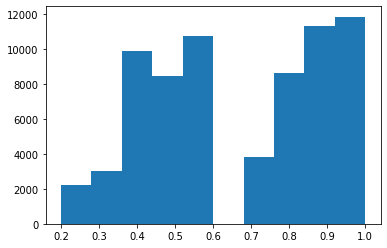

Unique y values:  [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Mean y value:  0.6802100000000001
Median y value:  0.7
Std y value:  0.23792000195143623


In [ ]:
plt.hist(y_train)
plt.show()

print('Unique y values: ', np.unique(y_train))
print('Mean y value: ', np.mean(y_train))
print('Median y value: ', np.median(y_train))
print('Std y value: ', np.std(y_train))

Review length:
Mean 154.47 words (stddev: 81.134751)


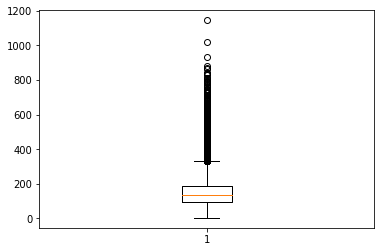

In [ ]:
print('Review length:')
train_texts_lengths = [len(x.split(' ')) for x in X_train_texts]
print("Mean %.2f words (stddev: %f)" % \
      (np.mean(train_texts_lengths),
       np.std(train_texts_lengths)))

# plot review lengths
plt.boxplot(train_texts_lengths)
plt.show()

In [ ]:
# Tokenize the texts and keep only the top n words

TOP_WORDS = 10000

tokenizer = create_tokenizer(X_train_texts, top_words=TOP_WORDS)

X_train = tokenizer.texts_to_sequences(X_train_texts)
X_val = tokenizer.texts_to_sequences(X_val_texts)
X_test = tokenizer.texts_to_sequences(X_test_texts)

print(len(X_train))
print(len(X_val))
print(len(X_test))

70000
3000
7000


In [ ]:
index_to_token = {tokenizer.word_index[k]: k for k in tokenizer.word_index.keys()}

In [ ]:
MAX_WORDS = 500

X_train = pad_sequences(X_train, max_words=MAX_WORDS)
X_val = pad_sequences(X_val, max_words=MAX_WORDS)
X_test = pad_sequences(X_test, max_words=MAX_WORDS)

In [ ]:
tf.reset_default_graph()
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_WORDS,)),
    tf.keras.layers.Embedding(TOP_WORDS, 100),
    tf.keras.layers.Conv1D(filters=128, strides=1,
                           kernel_size=3,
                           activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 128)          38528     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,038,657
Trainable params: 1,038,657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mse',  # binary_crossentropy
              metrics=['acc'])

# multi-input test
history = model.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val, y_val))

Train on 70000 samples, validate on 3000 samples
Epoch 1/10
70000/70000 [==============================] - ETA: 0s - loss: 0.0344 - acc: 0.1689

/Users/subhamsahoo/Library/Python/3.7/lib/python/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


70000/70000 [==============================] - 57s 816us/sample - loss: 0.0344 - acc: 0.1689 - val_loss: 0.0260 - val_acc: 0.1573
Epoch 2/10
70000/70000 [==============================] - 60s 859us/sample - loss: 0.0229 - acc: 0.1691 - val_loss: 0.0241 - val_acc: 0.1573
Epoch 3/10
70000/70000 [==============================] - 65s 924us/sample - loss: 0.0182 - acc: 0.1692 - val_loss: 0.0246 - val_acc: 0.1567
Epoch 4/10
70000/70000 [==============================] - 77s 1ms/sample - loss: 0.0140 - acc: 0.1693 - val_loss: 0.0253 - val_acc: 0.1567
Epoch 5/10
70000/70000 [==============================] - 74s 1ms/sample - loss: 0.0103 - acc: 0.1694 - val_loss: 0.0262 - val_acc: 0.1563
Epoch 6/10
70000/70000 [==============================] - 76s 1ms/sample - loss: 0.0074 - acc: 0.1694 - val_loss: 0.0271 - val_acc: 0.1567
Epoch 7/10
70000/70000 [==============================] - 73s 1ms/sample - loss: 0.0054 - acc: 0.1694 - val_loss: 0.0284 - val_acc: 0.1563
Epoch 8/10
70000/70000 [========

In [ ]:
def load_rationale_annotations(path, verbose=True):
  data = []
  fopen = gfile.Open(path, 'rb')
  if path.endswith(".gz"):
    fopen = gzip.GzipFile(fileobj=fopen)

  for line in fopen:
    item = json.loads(line)
    data.append(item)
  fopen.close()
  if verbose:
    print('Loaded %d annotations.' % len(data))
  return data


def retokenize_annotation(annotation, tokenizer, annotation_indices=None, count_missing=False):
  joined_annotation = ' '.join(annotation)
  retokenized = tokenizer.texts_to_sequences([joined_annotation])[0]
  if count_missing:
    word_sequence = text.text_to_word_sequence(joined_annotation,
                                                tokenizer.filters,
                                                tokenizer.lower,
                                                tokenizer.split)
    num_missing = len(word_sequence) - len(retokenized)
  else:
    num_missing = None
  return retokenized, num_missing

In [ ]:
annotations = load_rationale_annotations(
    os.path.join(BASE_PATH, 'annotations.json'))

Loaded 994 annotations.


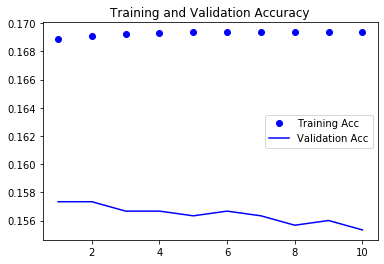

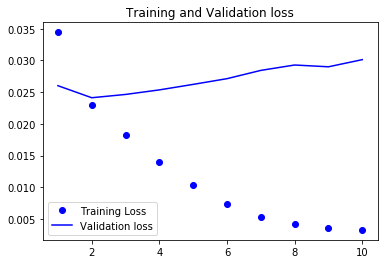

In [ ]:
# plotting the results
import matplotlib.pyplot as plt

acc = history.history.get('acc')
val_acc = history.history.get('val_acc')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
tf.saved_model.simple_save(
    session=tf.keras.backend.get_session(),
    export_dir='trained_text_model',
    inputs={'input': model.inputs[0]},
    outputs={'output': model.outputs[0]})

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: trained_text_model/saved_model.pb


### Generate Saliency Maps

In [ ]:
def pad_sequences(X, max_words=500):
    return keras.preprocessing.sequence.pad_sequences(X, maxlen=max_words)

def get_words(x, tokenizer):
  index_to_token = {
      tokenizer.word_index[k]: k for k in tokenizer.word_index.keys()}
  index_to_token[0] = ''
  words = []
  for i in x:
    if i != 0:
      words.append(index_to_token[i])
  return words


def highlight_ground_truth(review, limits):
  for lims in limits:
    for index in range(lims[0], lims[1], 1):
      review[index] = '<u>' + review[index] + '</u>'
  return review


def highlight_words(review, words, attributes):
  assert len(attributes) == len(words)
  previous_index = 0
  for word, attribute in zip(words, attributes):
    if word not in review:
      continue
    index = review[previous_index:].index(word)
    r, g, b = _get_color(attribute)
    review[previous_index + index] = (
        "<span style='color:rgb(%d,%d,%d)'>%s</span>" % (
            r, g, b, review[index]))
    # previous_index = index
  return review

def _get_color(attribute):
  if attribute > 0:
    return (128 - int(64*attribute),
            int(128*attribute) + 127,
            128 - int(64*attribute),)
  return (int(-128*attribute) + 127,
          128 + int(64*attribute),
          128 + int(64*attribute))


def highlight_text(annotation, aspect, words, attributes, print_html=False):
  # Color words
  review = highlight_words(
      review=list(annotation['x']),
      words=words,
      attributes=attributes)

  # Underline words
  review = highlight_ground_truth(
      review=review,
      limits=annotation[str(aspect)])

  # New for neurips - remove solid white
  for i, word in enumerate(review):
    if "<span style='color:rgb" not in word:
      review[i] = "<span style='color:rgb(128,127,128)'>{}</span>".format(word)
  display(HTML(' '.join(review)))
  
  if print_html:
    print(' '.join(review))


def get_words_with_attributes(x, attributes, tokenizer):
  index_to_token = {
      tokenizer.word_index[k]: k for k in tokenizer.word_index.keys()}
  index_to_token[0] = ''
  words = []
  _attributes = []
  max_attribute = np.percentile(attributes, 99)
  if max_attribute == 0:
    max_attribute = np.max(attributes)
  for i, j in zip(x, attributes):
    if i != 0:
      words.append(index_to_token[i])
      _attributes.append(j /max_attribute)
      # print(np.max(np.abs(attributes)), j, np.percentile(attributes, 99))
  return words, _attributes

In [ ]:
run_params = masking.RunParams(**{
  'model_path': 'trained_text_model',
  'image_placeholder_shape': (1, 500),
  'model_type': 'text_cnn',
  'padding': (0, 0),
  'strides': 1,
  'activations': None,
  'pixel_range': None,
  'tensor_names': {
        'input': 'input_1:0',
        'embedding': 'embedding/embedding_lookup/Identity_1:0',
        'first_layer': 'conv1d/BiasAdd:0',
        'first_layer_relu': 'conv1d/Relu:0',
        'logits': 'dense/BiasAdd:0',
        'softmax': 'dense/Sigmoid:0',
        'weights_layer_1': 'conv1d/conv1d/ExpandDims_1:0',
        'biases_layer_1': 'conv1d/BiasAdd/ReadVariableOp:0'
  }
})

In [ ]:
with utils.restore_model(run_params.model_path) as sess:
  run_output = sess.run(
      run_params.tensor_names,
      feed_dict={run_params.tensor_names['input']: np.random.rand(1, 500)
      })
  print('Model type: {}'.format(run_params.model_path.split('/')[-1]))
  for key, value in run_output.items():
    print(key, value.shape)
  print('\n')

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from trained_text_model/variables/variables
Model type: trained_text_model
input (1, 500)
embedding (1, 500, 100)
first_layer (1, 498, 128)
first_layer_relu (1, 498, 128)
logits (1, 1)
softmax (1, 1)
weights_layer_1 (1, 3, 100, 128)
biases_layer_1 (128,)




In [ ]:
annotation_x = pad_sequences([retokenize_annotation(
    annotation['x'], tokenizer)[0] for annotation in annotations])

annotation_y = np.array(
    [float(annotation['y'][ASPECT]) for annotation in annotations])

In [ ]:
def generate_saliency_maps(features, run_params):
  smug_result = masking.find_mask_first_layer(
    image=features,
    label_index=0, # Since only one output node
    run_params=run_params,
    window_size=1,
    score_method='integrated_gradients',
    top_k=100,
    gamma=0,
    timeout=600,
    num_unique_solutions=1,
  )
  smug_base_saliency = masking.get_no_minimization_mask(
    image=features,
    label_index=0,
    top_k=100,
    run_params=run_params)
  with utils.restore_model(run_params.model_path) as session:
    unmasked_predictions = session.run(
        run_params.tensor_names,
        feed_dict={run_params.tensor_names['input']: [features]})
    ig_saliency_map = np.sum(masking.get_saliency_map(
        session=session,
        features=unmasked_predictions['embedding'][0],
        saliency_method='integrated_gradients',
        input_tensor_name=run_params.tensor_names['embedding'],
        output_tensor_name=run_params.tensor_names['softmax'],
        label=0), axis=1)
  return (smug_result['masks'][0] * smug_base_saliency,
          smug_base_saliency, ig_saliency_map)

In [ ]:
def _get_features_and_annotation_from_index(index):
  return annotation_x[index], annotations[index]
features, annotation = _get_features_and_annotation_from_index(10)

smug_saliency, smug_base_saliency, ig_saliency = generate_saliency_maps(
  features, run_params)
highlight_params = []

smug_words, smug_attributes = get_words_with_attributes(
    features, smug_saliency, tokenizer)
highlight_params.append(('Smug', smug_words, smug_attributes))

smug_base_words, smug_base_attributes = get_words_with_attributes(
    features, smug_base_saliency, tokenizer)
highlight_params.append(
  ('No_minimization', smug_base_words, smug_base_attributes))

ig_words, ig_attributes = get_words_with_attributes(
    features, ig_saliency, tokenizer)
highlight_params.append(('IG', ig_words, ig_attributes))

for method, words, attributes in highlight_params:
  print(method)
  highlight_text(
      annotation=annotation,
      aspect=ASPECT,
      words=words,
      attributes=attributes,
      print_html=False)
  print('')

INFO:tensorflow:Restoring parameters from trained_text_model/variables/variables
INFO:tensorflow:Restoring parameters from trained_text_model/variables/variables
INFO:tensorflow:Restoring parameters from trained_text_model/variables/variables
Smug



No_minimization



IG
